In [18]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import DataProcessing
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import LSTM, Dense,Input, Dropout,Attention, Activation, Flatten, TimeDistributed, RepeatVector, Permute, Multiply, Lambda,Bidirectional
from keras import backend as K
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from keras_self_attention import SeqSelfAttention
import tensorflow as tf

dataProcess = DataProcessing.ETL()
path1='./historical_data/Binance_ETHUSDT_d.csv'
path2= './historical_data/Binance_BTCUSDT_d.csv'
df = dataProcess.Load_Clean_Data(path1,'1d')

cols= ['ti_stoch_kd','ti_MACD']
cols_to_normalize = ['open','high', 'low', 'close', 'base_volume'] # removed num_trades
df = dataProcess.Add_TI_Data(df, cols=cols)
df= dataProcess.Add_Label(df,cols_to_normalize=cols_to_normalize)
#important: reverse the order and Reset the index to start from 0
df= df[::-1]
df.reset_index(drop=True, inplace=True)


#removed time ('unix_start_datetime')
x_cols = cols_to_normalize+cols
labels = ['result_A','result_B']
tensor_temp= df[x_cols+labels]
sequence_num=14 # also called timesteps
tensor = dataProcess.create_tensor_with_sequence(tensor_temp,labels,sequence_num)
#note we have 2 labels, one for daily(B) another for shortterm (A) => shorterm>daily
#y1= df['result_A']
X= tensor.loc[:,~tensor.columns.isin(labels)]


y2= tensor['result_B']

y = y2.replace({'up': 0, 'down': 1, 'flat':2})
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y)
y = to_categorical(y, num_classes=3)



# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
# further split training data into training and validation sets
# # Create the oversampling object
# # Oversample the data

# smote = SMOTE()
# X_train, y_train = smote.fit_resample(X_train, y_train)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, shuffle=False)

# Important: reshape it into a 3D tensor with dimensions (number of samples, sequence length, number of features) to process with LSTM
X_train = X_train.to_numpy().reshape(X_train.shape[0],sequence_num+1,len(x_cols))
X_test = X_test.to_numpy().reshape(X_test.shape[0],sequence_num+1,len(x_cols))
X_val = X_val.to_numpy().reshape(X_val.shape[0],sequence_num+1,len(x_cols))

model = Sequential([
Bidirectional(LSTM(units=110, return_sequences=True, input_shape=(sequence_num+1,len(x_cols)))),
Dropout(0.4),
Bidirectional(LSTM(units=64,
                    return_sequences=True
                    )),
Dropout(0.6),
Bidirectional(
    LSTM(
    units=32,
    return_sequences=True
    )),
Dropout(0.6),
SeqSelfAttention(attention_activation='tanh'),
Flatten(),
Dense(3,activation='softmax')])


model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.TruePositives(name='tp'),
                       tf.keras.metrics.FalsePositives(name='fp'),
                       tf.keras.metrics.TrueNegatives(name='tn'),
                       tf.keras.metrics.FalseNegatives(name='fn'),
                       ])
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs= 30)

created
Epoch 1/30


/opt/homebrew/Caskroom/miniforge/base/envs/ML/lib/python3.8/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


31/31 [==============================] - 6s 53ms/step - loss: 0.9689 - accuracy: 0.4699 - precision_10: 0.4941 - recall_10: 0.1713 - tp: 168.0000 - fp: 172.0000 - tn: 1790.0000 - fn: 813.0000 - val_loss: 0.9083 - val_accuracy: 0.5321 - val_precision_10: 0.5519 - val_recall_10: 0.4038 - val_tp: 170.0000 - val_fp: 138.0000 - val_tn: 704.0000 - val_fn: 251.0000
Epoch 2/30
31/31 [==============================] - 1s 26ms/step - loss: 0.9183 - accuracy: 0.5209 - precision_10: 0.5452 - recall_10: 0.3445 - tp: 338.0000 - fp: 282.0000 - tn: 1680.0000 - fn: 643.0000 - val_loss: 0.9224 - val_accuracy: 0.5178 - val_precision_10: 0.5327 - val_recall_10: 0.4252 - val_tp: 179.0000 - val_fp: 157.0000 - val_tn: 685.0000 - val_fn: 242.0000
Epoch 3/30
31/31 [==============================] - 1s 25ms/step - loss: 0.9108 - accuracy: 0.4985 - precision_10: 0.5483 - recall_10: 0.3180 - tp: 312.0000 - fp: 257.0000 - tn: 1705.0000 - fn: 669.0000 - val_loss: 0.9349 - val_accuracy: 0.4893 - val_precision_10: 0.

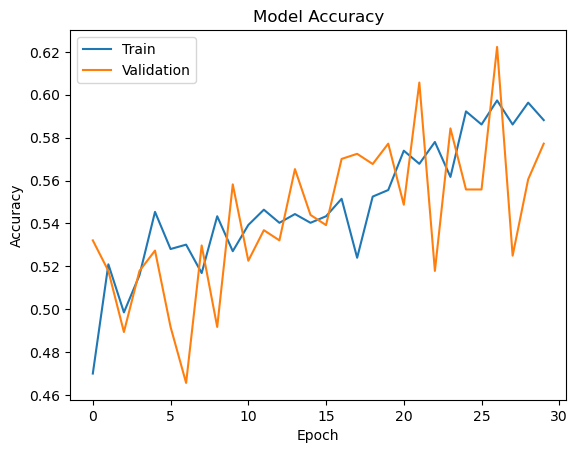

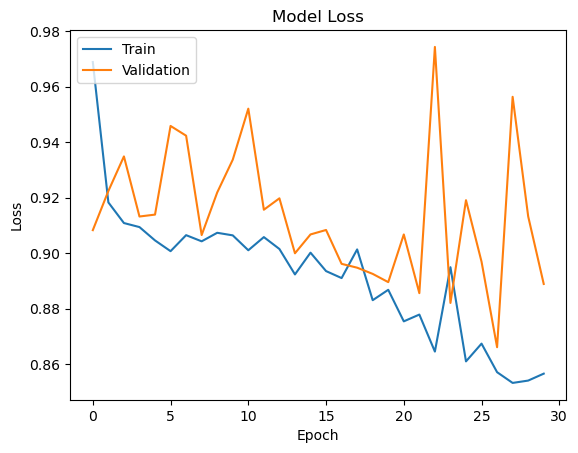

19/19 [==============================] - 0s 7ms/step - loss: 0.9359 - accuracy: 0.5731 - precision_10: 0.5881 - recall_10: 0.5100 - tp: 307.0000 - fp: 215.0000 - tn: 989.0000 - fn: 295.0000
Accuracy: 0.5730897188186646
Precision: 0.5881226062774658
Recall: 0.5099667906761169
F1 Score: 0.5462633532014166
True Positive: 307.0
True Negative: 989.0
False Positive: 215.0
False Negative: 295.0


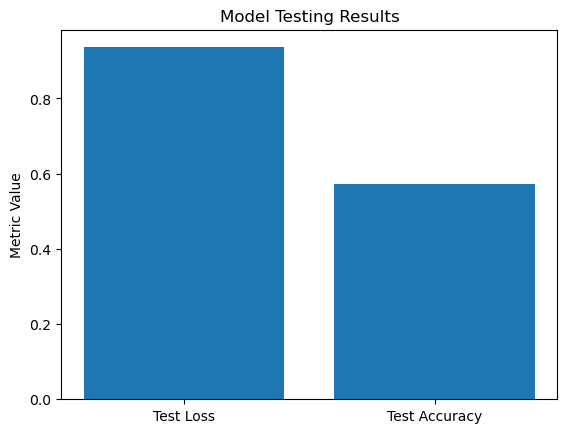

14/14 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

           0       0.45      0.86      0.59       170
           1       0.70      0.31      0.43       216
           2       0.00      0.00      0.00        35

   micro avg       0.51      0.51      0.51       421
   macro avg       0.38      0.39      0.34       421
weighted avg       0.54      0.51      0.46       421
 samples avg       0.51      0.51      0.51       421



/opt/homebrew/Caskroom/miniforge/base/envs/ML/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
#data visualization and summerization
dataProcess.visualizeValidation(history)

loss, accuracy, precision, recall, tp, fp, tn, fn = model.evaluate(X_test, y_test)

# # Calculate precision, recall, and F1 score
# precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average= None)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", (2*(recall*precision)/(recall + precision)))
print("True Positive:", tp)
print("True Negative:", tn)
print("False Positive:", fp)
print("False Negative:", fn)

# Plot testing accuracy and loss
plt.bar(['Test Loss', 'Test Accuracy'], [loss, accuracy])
plt.title('Model Testing Results')
plt.ylabel('Metric Value')
plt.show()

y_pred = model.predict(X_val)

result = dataProcess.getPredictionData(y_pred)
print(classification_report(y_val, result))